# 1x2 MMI Splitter Design with Optimizable Tapers (Generated by Script)

This notebook designs a 1x2 Multimode Interference (MMI) splitter with taper sections optimized using Luminescent AI.

In [ ]:
import os
os.environ['PATH'] += ':/home/oslab/Luminescent/bin'

## 2. MMI and Simulation Parameters

running luminescent python frontend
2025-06-03 05:16:43.016 | WARNING  | kfactory.kcell:show:3516 - Could not connect to klive server


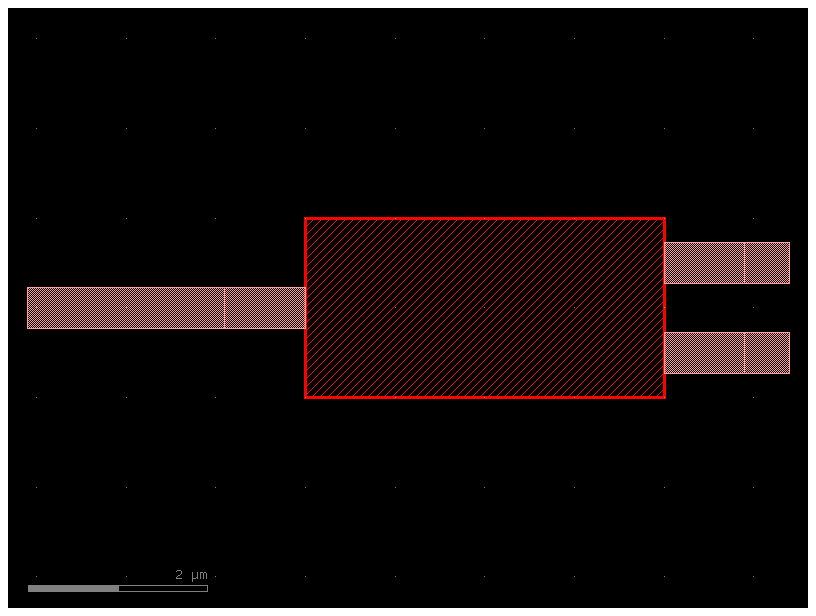

In [1]:
import os
import luminescent as lumi
from luminescent import DESIGN, WG, CLAD
import gdsfactory as gf
from gdsfactory.technology import LogicalLayer, LayerLevel, LayerStack

path = os.path.join("runs", "mmisplitter")
length = 4 # 增加长度（MMI 需要更长的多模区域）
width = 2  # 增加宽度（容纳多模干涉）
width_wg = 0.45

# margins
source_port_margin = 2
port_margin = 0.5
xmargin_mode = 0.6

# 创建组件
c = gf.Component()

# 使用 lumi.mimo 定义 MMI 结构（移除 io 参数）
dut = c << lumi.mimo(
    length,
    width,
    west=1,   # 输入端口（1 个）
    east=2,   # 输出端口（2 个）
    width_wg=width_wg,
    layer=WG,
    design_layer=DESIGN,
)

# 添加扩展波导（输入和输出）
ext1 = c << gf.components.straight(1.1 * source_port_margin, width=width_wg)
ext2 = c << gf.components.straight(port_margin, width=width_wg)
ext3 = c << gf.components.straight(port_margin, width=width_wg)

# 连接端口
ext1.connect("o2", dut.ports["o1"])      # 输入
ext2.connect("o1", dut.ports["o2"])    # 输出 1
ext3.connect("o1", dut.ports["o3"])    # 输出 2

# 添加所有端口到组件
c.add_port("o1", port=dut.ports["o1"])
c.add_port("o2", port=dut.ports["o2"])
c.add_port("o3", port=dut.ports["o3"])

# 添加 CLAD 层边界
c << gf.components.bbox(component=c, layer=CLAD, top=1, bottom=1)
c.plot()
c.show()


xmargin_mode: [0.6, 0.6]
using simulation folder runs/mmisplitter
loading problem from /home/oslab/Luminescent.jl/runs/mmisplitter

running Luminescent julia backend
λ = F(center_wavelength) = 1.55f0
setting up simulation...
meshing geometry - can take few minutes...
12.385052 seconds (9.62 M allocations: 577.445 MiB, 15.32% gc time, 81.00% compilation time)
making sources...
solving modal profile...
2d
making monitors...
solving modal profile...
2d
solving modal profile...
2d
solving modal profile...
2d
making designs...
----------------------------------------

simulation setup complete

backend: CPU
float: Float32

original size: (115, 41)
padded size: (145, 57)
cell count: 8,265

step size: 23.0 steps/period
max time: 30.00 periods
time steps: 690

computation load: 5,702,850 cell-steps

compiling simulation code...
starting optimization... first iter will be slow due to adjoint compilation.

[1]
376.611937 seconds (66.58 M allocations: 11.092 GiB, 6.97% gc time, 19.62% compilation

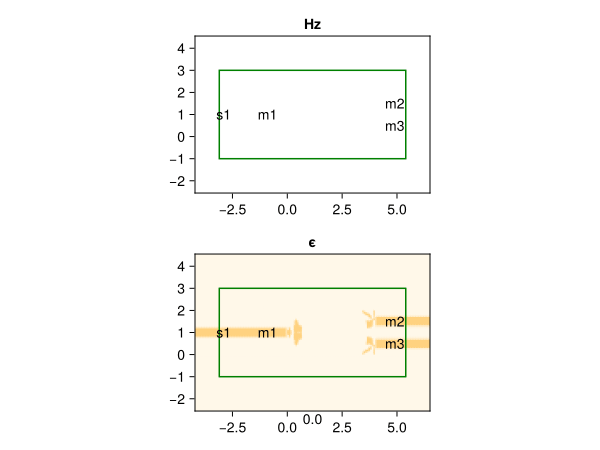

In [2]:
# 优化目标：均分光功率（50% 到 o2 和 o3）

targets = [
    lumi.Target("o2@0,o1@0", 0.5, weight=0.5, wavelength=1.55)
] + [lumi.Target("o3@0,o1@0", 0.5, weight=0.5, wavelength=1.55)]

lumi.make_prob(
    path,  # path to make problem folder
    c,
    targets=targets,
    symmetries=["y"],
    #
    materials=lumi.MATERIALS,
    layer_stack=lumi.SOI220,
    approx_2D_mode="TE",  # makes problem 2.5D instead of 3D
    #
    lmin=0.15,  # approximate minimum feature size
    fill_material="Si",
    void_material="SiO2",
    #
    source_port_margin=source_port_margin,
    xmargin_mode=xmargin_mode,
    #'
    relcourant=0.90,  # relative courant number between 0 and 1
    nres=6,  # number of grid points per wavelength in material (not vacuum)
    T=30,
    #
    init_holes=True,  # initialize holes in design region
    stoploss=0.05,
    iters=100,  # max iters
    #
    saveat=5,  # save frame every `saveat` periods for movie
    force=True,  # delete and overwrite existing path
)

# 运行仿真并生成动画
lumi.solve(path)
lumi.make_movie(path)

## 4. LayerStack and Materials

In [3]:
import matplotlib.pyplot as plt
import os
import luminescent as lumi
from luminescent import DESIGN, WG, CLAD
import gdsfactory as gf
from gdsfactory.technology import LogicalLayer, LayerLevel, LayerStack
os.environ['PATH'] += ':/home/oslab/Luminescent/bin'
path = os.path.join("runs", f"mmi_splitter")
                    
sol = lumi.load_sol(path)
wavelengths = np.linspace(1.5, 1.6, 100) 
x = wavelengths
# 提取透射率数据
T_o2 = sol["T"]["o2@0,o1@0"]  # o1→o2 的透射率
T_o3 = sol["T"]["o3@0,o1@0"]  # o1→o3 的透射率
# 绘制结果
plt.figure(figsize=(10, 6))
plt.plot(wavelengths, T_o2, label="Output Port o2 (TE)", color="blue")
plt.plot(wavelengths, T_o3, label="Output Port o3 (TE)", color="red")

# 标注目标波长（如优化时用的 1.55µm）
target_wl = 1.55
plt.axvline(x=target_wl, color="gray", linestyle="--", alpha=0.5)
plt.text(target_wl+0.01, 0.9, f"Target λ={target_wl}µm", rotation=90, va="top")

# 图表格式
plt.xlabel("Wavelength (µm)")
plt.ylabel("Transmission")
plt.title("MMI Splitter Performance")
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 1.1)  # 限制y轴范围
plt.show()

loading solution from /home/oslab/Luminescent.jl/runs/mmi_splitter


FileNotFoundError: [Errno 2] No such file or directory: '/home/oslab/Luminescent.jl/runs/mmi_splitter/solution.json'

## 5. Optimization Targets

## 6. Configure and Create Simulation Problem (lumi.make_prob)

## 7. Run Optimization and Create Movie

## 8. Load and Plot Results (Illustrative)